Business Problem:
- Problem: A financial consulting firm needs to advise Vietnamese banks on strategic positioning to optimize growth, manage risk, and enhance competitiveness in a dynamic market.
-Solution: Use clustering to segment banks based on their financial profiles (e.g., asset size, liquidity, loan portfolio, profitability) in Q3 2023. This segmentation will help identify peer groups, assess risk profiles, and recommend tailored strategies (e.g., expansion, cost optimization, or risk mitigation).

Objective: Cluster banks to uncover patterns (e.g., large vs. small banks, high-risk vs. stable banks) and provide actionable recommendations for strategic decision-making.

In [ ]:
from google.colab import files
info = files.upload()

Saving BCTC_Bank.xlsx to BCTC_Bank.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_excel('BCTC_Bank.xlsx')


Insights:
- Contains financial metrics (e.g., Total Assets, Customer Loans, Equity, Profit) for 7 banks (BAB, LPB, NVB, PGB, SGB, TPB, VPB) in Q3 2023, with additional Q4 2023 data for some banks, historical profit data (2008–2023) for VCB, VIB, and VPB, and Q1 2024 sector-specific loan data.
- Key metrics: Total Assets, Customer Loans, Equity, Cash and Equivalents, Investment Securities, Net Cash Flow from Operations, Profit After Tax.

In [ ]:
# Data Overview
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique Values per Column:\n", df.nunique())

Dataset Shape: (253304, 9)

Columns: ['ID', 'TICKER', 'NAME', 'exchangeCode', 'dataType', 'Quarter', 'Year', 'Metric', 'Value']

Data Types:
 ID                int64
TICKER           object
NAME             object
exchangeCode     object
dataType         object
Quarter           int64
Year              int64
Metric           object
Value           float64
dtype: object

Missing Values:
 ID                  0
TICKER              0
NAME                0
exchangeCode        0
dataType            0
Quarter             0
Year                0
Metric              0
Value           27741
dtype: int64

Unique Values per Column:
 ID                  27
TICKER              27
NAME                28
exchangeCode         3
dataType             1
Quarter              4
Year                17
Metric             195
Value           106176
dtype: int64


Insights:
- Dataset Size: 253,304 rows, 9 columns.
- Columns: Includes bank identifiers (ID, TICKER, NAME), exchange info, time (Quarter, Year), and financial metrics (Metric, Value).
- Missing Values: 27,741 in Value (10.95%)—needs preprocessing for clustering.
- Unique Values: 27 banks, 3 exchanges, 4 quarters, 17 years, 195 metrics—diverse data for segmentation; slight NAME inconsistency (28 vs. 27 TICKERs).

In [ ]:
#Check every metric in the Metric column
print(df['Metric'].unique())

['CĐKT. TỔNG CỘNG TÀI SẢN' 'CĐKT. Tiền và tương đương tiền '
 'CĐKT. Tiền gửi tại ngân hàng nhà nước Việt Nam'
 'CĐKT. Tiền gửi tại các TCTD khác và cho vay các TCTD khác'
 'CĐKT. Chứng khoán kinh doanh'
 'CĐKT. Các công cụ tài chính phái sinh và các tài sản tài chính khác'
 'CĐKT. Cho vay khách hàng' 'CĐKT. Dự phòng rủi ro cho vay khách hàng'
 'CĐKT. Chứng khoán đầu tư' 'CĐKT. Đầu tư dài hạn' 'CĐKT. Tài sản cố định'
 'CĐKT. GTCL TSCĐ hữu hình' 'CĐKT. GTCL Tài sản thuê tài chính'
 'CĐKT.GTCL tài sản cố định vô hình' 'CĐKT. Giá trị ròng tài sản đầu tư'
 'CĐKT. Tài sản Có khác' 'CĐKT. TỔNG CỘNG NGUỒN VỐN' 'CĐKT. NỢ PHẢI TRẢ'
 'CĐKT. Các khoản nợ chính phủ và NHNN Việt Nam'
 'CĐKT. Tiền gửi và vay các Tổ chức tín dụng khác'
 'CĐKT. Tiền gửi của khách hàng'
 'CĐKT. Các công cụ tài chính phái sinh và các khoản nợ tài chính khác'
 'CĐKT. Vốn tài trợ, uỷ thác đầu tư của Chính phủ và các tổ chức tín dụng khác'
 'CĐKT. Phát hành giấy tờ có giá' 'CĐKT. Các khoản nợ khác'
 'CĐKT. VỐN CHỦ SỞ HỮU' 

Insights:
- The 195 unique metrics contain financial data, with columns representing various financial metrics (in Vietnamese) related to balance sheets (CĐKT), income statements (KQKD), cash flow statements (LCTT), and other financial activities (TM).

EDA

In [ ]:
# Filter for Q3 2023
df_q3_2023 = df[(df['Quarter'] == 3) & (df['Year'] == 2023)]
metrics = df_q3_2023['Metric'].unique()
# Print the list of unique metrics
print("Unique Metrics for Q3 2023:")
for metric in metrics:
    print(metric)

Unique Metrics for Q3 2023:
CĐKT. TỔNG CỘNG TÀI SẢN
CĐKT. Tiền và tương đương tiền 
CĐKT. Tiền gửi tại ngân hàng nhà nước Việt Nam
CĐKT. Tiền gửi tại các TCTD khác và cho vay các TCTD khác
CĐKT. Chứng khoán kinh doanh
CĐKT. Các công cụ tài chính phái sinh và các tài sản tài chính khác
CĐKT. Cho vay khách hàng
CĐKT. Dự phòng rủi ro cho vay khách hàng
CĐKT. Chứng khoán đầu tư
CĐKT. Đầu tư dài hạn
CĐKT. Tài sản cố định
CĐKT. GTCL TSCĐ hữu hình
CĐKT. GTCL Tài sản thuê tài chính
CĐKT.GTCL tài sản cố định vô hình
CĐKT. Giá trị ròng tài sản đầu tư
CĐKT. Tài sản Có khác
CĐKT. TỔNG CỘNG NGUỒN VỐN
CĐKT. NỢ PHẢI TRẢ
CĐKT. Các khoản nợ chính phủ và NHNN Việt Nam
CĐKT. Tiền gửi và vay các Tổ chức tín dụng khác
CĐKT. Tiền gửi của khách hàng
CĐKT. Các công cụ tài chính phái sinh và các khoản nợ tài chính khác
CĐKT. Vốn tài trợ, uỷ thác đầu tư của Chính phủ và các tổ chức tín dụng khác
CĐKT. Phát hành giấy tờ có giá
CĐKT. Các khoản nợ khác
CĐKT. VỐN CHỦ SỞ HỮU
CĐKT. Vốn của tổ chức tín dụng
CĐKT. Cổ p

In [ ]:
df_q3_2023.head()

,ID,TICKER,NAME,exchangeCode,dataType,Quarter,Year,Metric,Value
0,3422,BAB,Ngân hàng Bắc Á,HNX,Bank,3,2023,CĐKT. TỔNG CỘNG TÀI SẢN,1.450006e+14
1,3167,LPB,LienVietPostBank,HOSE,Bank,3,2023,CĐKT. TỔNG CỘNG TÀI SẢN,3.654502e+14
2,3533,NVB,Ngân hàng Quốc Dân,HNX,Bank,3,2023,CĐKT. TỔNG CỘNG TÀI SẢN,9.160019e+13
3,3507,PGB,PG Bank,UPCoM,Bank,3,2023,CĐKT. TỔNG CỘNG TÀI SẢN,4.783264e+13
4,3786,SGB,Sài Gòn Công thương,UPCoM,Bank,3,2023,CĐKT. TỔNG CỘNG TÀI SẢN,2.968140e+13


Filter metrics for Q3 2023

In [ ]:
# Print the total number of unique metrics
print(f"\nTotal number of unique metrics: {len(metrics)}")


Total number of unique metrics: 192


=> After filtering, the total number of metrics reduced from 195 to 192 metrics

In [ ]:
df_filtered = df_q3_2023[df_q3_2023['Metric'].isin(metrics)]

=> Filter relevant 192 financial metrics for Q3 2023

In [ ]:
# Pivot data
df_pivot = df_filtered.pivot(index='TICKER', columns='Metric', values='Value')

Apply pivot to convert every metric into features for clustering

In [ ]:
# Check the new pivot data
df_pivot.head(100)

Metric,BCTCKH. Doanh thu thuần,BCTCKH. Lợi nhuận sau thuế thu nhập doanh nghiệp,BCTCKH. Tổng lợi nhuận kế toán trước thuế,CĐKT. Cho vay khách hàng,CĐKT. Chứng khoán kinh doanh,CĐKT. Chứng khoán đầu tư,CĐKT. Các công cụ tài chính phái sinh và các khoản nợ tài chính khác,CĐKT. Các công cụ tài chính phái sinh và các tài sản tài chính khác,CĐKT. Các khoản nợ chính phủ và NHNN Việt Nam,CĐKT. Các khoản nợ khác,...,TM. Tiền gửi tiết kiệm,TM. Trả lãi phát hành trái phiếu và giấy tờ có giá,TM. Trả lãi tiền gửi,TM. Trả lãi tiền vay,TM. VNĐ,TM. Xây dựng,TM. Đồng bằng sông Cửu Long,TM.Chiết khấu thương phiếu và giấy tờ có giá,TM.Thương mại,Trạng thái kiểm toán
TICKER,,,,,,,,,,,,,,,,,,,,,
ABB,NaN,NaN,NaN,8.045475e+13,1.426325e+12,1.608568e+13,2.468460e+11,0.000000e+00,0.000000e+00,4.342493e+12,...,0.000000e+00,1.517080e+11,1.818351e+12,7.635900e+10,0.000000e+00,0.000000e+00,0.0,1.362178e+12,0.000000e+00,-1.0
ACB,NaN,NaN,NaN,4.446415e+14,1.892458e+12,7.023316e+13,0.000000e+00,7.921000e+10,1.855200e+10,2.314281e+13,...,2.658481e+14,3.167060e+11,6.066890e+12,7.835500e+10,0.000000e+00,0.000000e+00,0.0,6.878300e+10,0.000000e+00,-1.0
BAB,NaN,NaN,NaN,9.754271e+13,2.197385e+13,1.024494e+13,2.812500e+10,0.000000e+00,2.993100e+10,4.260425e+12,...,0.000000e+00,1.107580e+11,2.739272e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,-1.0
BID,NaN,NaN,NaN,1.611644e+15,5.577810e+12,2.075530e+14,3.978070e+11,0.000000e+00,1.324200e+13,5.423056e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
BVB,NaN,NaN,NaN,5.224264e+13,0.000000e+00,1.125778e+13,5.760000e+08,0.000000e+00,0.000000e+00,2.031981e+12,...,0.000000e+00,2.243540e+11,1.097137e+12,3.221200e+10,5.279410e+13,4.564476e+12,0.0,0.000000e+00,2.350388e+13,-1.0
CTG,NaN,NaN,NaN,1.353619e+15,1.567526e+12,1.634275e+14,5.040600e+10,0.000000e+00,2.157702e+13,5.539290e+13,...,0.000000e+00,1.737530e+12,1.717782e+13,7.044050e+11,0.000000e+00,0.000000e+00,0.0,1.434577e+12,0.000000e+00,-1.0
EIB,NaN,NaN,NaN,1.345786e+14,0.000000e+00,4.848053e+12,0.000000e+00,9.768200e+10,2.162200e+10,4.874759e+12,...,0.000000e+00,0.000000e+00,2.636035e+12,1.920000e+08,1.221650e+14,0.000000e+00,0.0,5.005660e+11,0.000000e+00,-1.0
HDB,NaN,NaN,NaN,2.881368e+14,2.159961e+13,5.104145e+13,2.722220e+11,0.000000e+00,2.982900e+10,1.674095e+13,...,0.000000e+00,9.012240e+11,6.702517e+12,8.592530e+11,0.000000e+00,2.214679e+13,0.0,2.531940e+11,1.864489e+13,-1.0
KLB,NaN,NaN,NaN,4.729505e+13,1.075358e+12,5.650566e+12,1.035580e+11,0.000000e+00,0.000000e+00,4.314575e+12,...,5.234207e+13,2.854000e+10,1.268119e+12,7.476000e+10,4.767105e+13,7.946724e+12,0.0,0.000000e+00,4.161218e+12,-1.0


In [ ]:
# Extract KQKD columns
kqkd_columns = [col for col in df_pivot.columns if col.startswith('KQKD.')]
kqkd_df = df_pivot[kqkd_columns]

#Check the data that will be used for analysis
kqkd_df.head(100)

Metric,KQKD. Chi phí dự phòng rủi ro tín dụng,KQKD. Chi phí hoạt động,KQKD. Chi phí lãi và các chi phí tương tự,KQKD. Chi phí thuế thu nhập doanh nghiệp,KQKD. Cổ đông của Công ty mẹ,"KQKD. Khấu hao TSCĐ, bất động sản đầu tư",KQKD. LN thuần từ hoạt động kinh doanh trước CP dự phòng rủi ro tín dụng,KQKD. Lãi cơ bản trên cổ phiếu,KQKD. Lãi thuần từ hoạt động dịch vụ,KQKD. Lãi/lỗ thuần từ hoạt động khác,...,KQKD. Lãi/lỗ thuần từ mua bán chứng khoán kinh doanh,KQKD. Lãi/lỗ thuần từ mua bán chứng khoán đầu tư,KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp,KQKD. Lợi nhuận trước thuế,KQKD. Lợi ích của cổ đông thiểu số,KQKD. Thu nhập lãi thuần,KQKD. Thu nhập lãi và các khoản thu nhập tương tự,"KQKD. Thu nhập từ góp vốn, mua cổ phần",KQKD. Tổng lợi nhuận kế toán trước thuế,KQKD. Tổng thu nhập hoạt động
TICKER,,,,,,,,,,,,,,,,,,,,,
ABB,-2.358600e+11,-5.549820e+11,-2.052366e+12,-5.972000e+09,2.352900e+10,0.0,2.653610e+11,0.0,1.893660e+11,1.114000e+10,...,5.124000e+09,-1.559400e+11,2.352900e+10,0.0,0.000000e+00,6.477270e+11,2.700093e+12,1.759200e+10,2.950100e+10,8.203430e+11
ACB,-5.206830e+11,-2.868218e+12,-6.814777e+12,-9.979020e+11,4.037579e+12,0.0,5.556164e+12,0.0,7.635870e+11,1.470370e+11,...,6.776000e+10,8.819420e+11,4.037579e+12,0.0,0.000000e+00,6.209128e+12,1.302390e+13,3.916600e+10,5.035481e+12,8.424382e+12
BAB,-2.808300e+10,-4.069940e+11,-2.850115e+12,-1.327600e+10,6.383900e+10,0.0,1.051980e+11,0.0,2.328800e+10,2.617000e+09,...,0.000000e+00,1.331500e+10,6.383900e+10,0.0,0.000000e+00,4.262390e+11,3.276354e+12,1.155000e+10,7.711500e+10,5.121920e+11
BID,-5.949617e+12,-6.044456e+12,-2.432119e+13,-1.164853e+12,4.582880e+12,0.0,1.184240e+13,0.0,1.764252e+12,7.410180e+11,...,1.144100e+11,-2.948740e+11,4.727935e+12,0.0,-1.450550e+11,1.378310e+13,3.810429e+13,9.631900e+10,5.892788e+12,1.788686e+13
BVB,-4.387300e+10,-3.929590e+11,-1.354786e+12,-4.589000e+09,1.705600e+10,0.0,6.551800e+10,0.0,1.660800e+10,3.546000e+09,...,0.000000e+00,4.122700e+10,1.705600e+10,0.0,0.000000e+00,3.979910e+11,1.752777e+12,0.000000e+00,2.164500e+10,4.584770e+11
CTG,-7.440325e+12,-5.081879e+12,-1.975038e+13,-9.756280e+11,3.863075e+12,0.0,1.231128e+13,0.0,1.815170e+12,1.409768e+12,...,-1.995000e+10,-1.298700e+10,3.895322e+12,0.0,-3.224700e+10,1.308744e+13,3.283782e+13,-2.159700e+10,4.870950e+12,1.739315e+13
EIB,-1.700130e+11,-7.579890e+11,-2.639171e+12,-6.512900e+10,2.418110e+11,0.0,4.769530e+11,0.0,1.155780e+11,3.167900e+10,...,0.000000e+00,1.414970e+11,2.418110e+11,0.0,0.000000e+00,8.687360e+11,3.507907e+12,2.780000e+08,3.069400e+11,1.234942e+12
HDB,-6.360890e+11,-2.301873e+12,-8.474740e+12,-6.321080e+11,2.480440e+12,0.0,3.783355e+12,0.0,3.179590e+11,1.148970e+11,...,2.993600e+10,5.163240e+11,2.515158e+12,0.0,-3.471800e+10,4.916148e+12,1.339089e+13,4.101000e+09,3.147266e+12,6.085228e+12
KLB,-9.169900e+10,-3.699480e+11,-1.448710e+12,-4.796700e+10,1.892350e+11,0.0,3.289010e+11,0.0,1.613080e+11,3.018900e+10,...,0.000000e+00,3.380900e+10,1.892350e+11,0.0,0.000000e+00,4.551140e+11,1.903824e+12,0.000000e+00,2.372020e+11,6.988490e+11


=> Choose KQKD (Income Statement) for Clustering as it directly reflects profitability, operational efficiency, and financial performance, aligning with goal.

In [ ]:
# Select numerical columns (exclude TICKER, Quarter, Year)
numerical_cols = kqkd_df.select_dtypes(include=['float64', 'int64']).columns

Extract relevant numerical columns except TICKER, Quarter, Year as these features do not contribute to the clustering analysis

In [ ]:
numerical_cols = numerical_cols[:10]  # Plot first 10 features

There are 192 columns -> cannot visualize all -> choose the first 10 columns

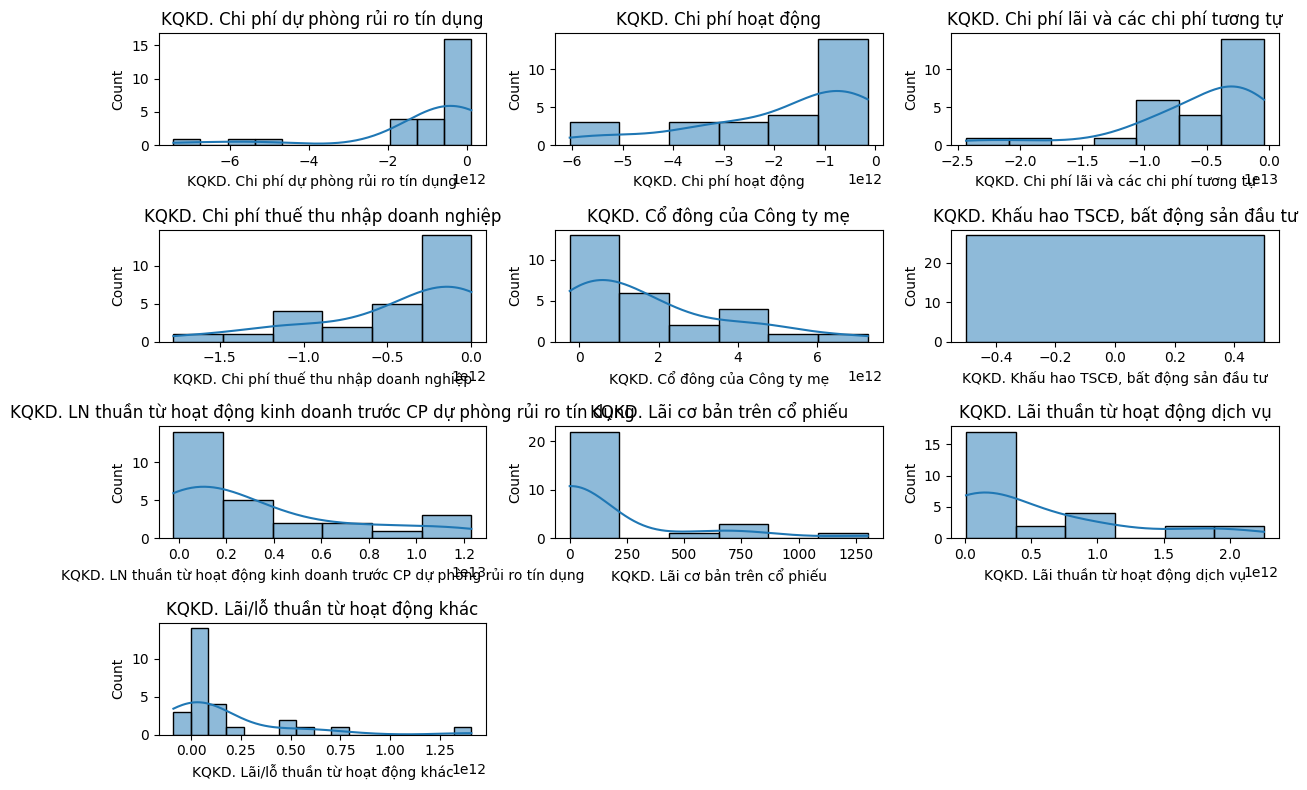

In [ ]:
# Visualize feature distributions
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.histplot(kqkd_df[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

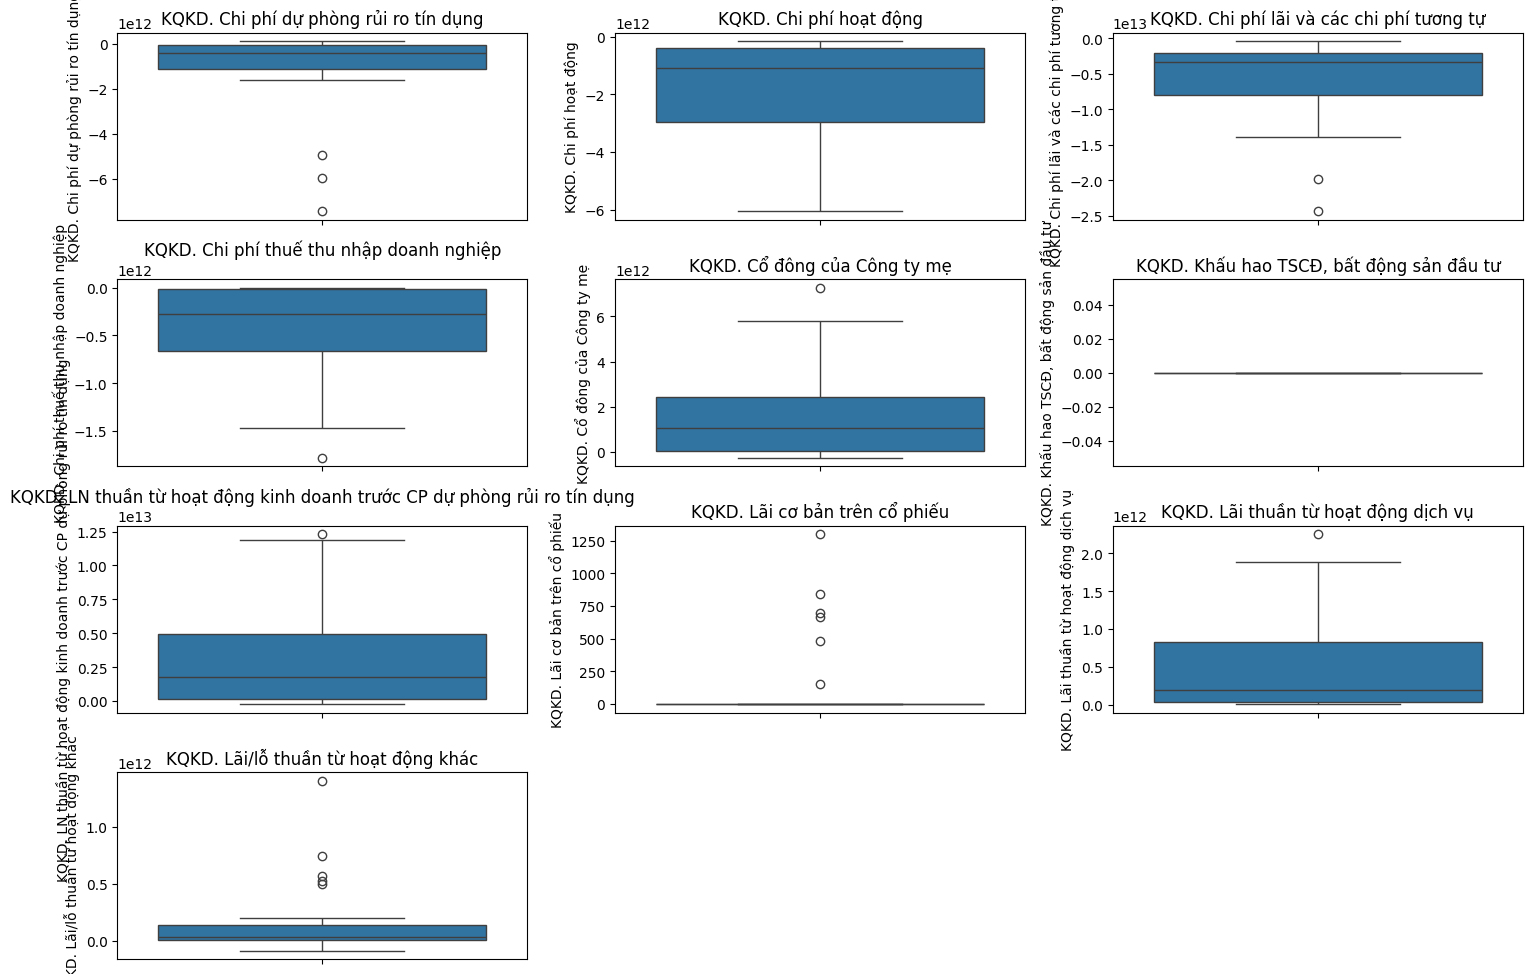

In [ ]:
# Boxplots for Outlier Detection
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) // 3) + 1, 3, i)
    sns.boxplot(y=kqkd_df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [ ]:
print("Dataset Shape:", kqkd_df.shape)
print("\nColumns:", kqkd_df.columns.tolist())
print("\nData Types:\n", kqkd_df.dtypes)
print("\nMissing Values:\n", kqkd_df.isnull().sum())

Dataset Shape: (27, 21)

Columns: ['KQKD. Chi phí dự phòng rủi ro tín dụng', 'KQKD. Chi phí hoạt động', 'KQKD. Chi phí lãi và các chi phí tương tự', 'KQKD. Chi phí thuế thu nhập doanh nghiệp', 'KQKD. Cổ đông của Công ty mẹ', 'KQKD. Khấu hao TSCĐ, bất động sản đầu tư', 'KQKD. LN thuần từ hoạt động kinh doanh trước CP dự phòng rủi ro tín dụng', 'KQKD. Lãi cơ bản trên cổ phiếu', 'KQKD. Lãi thuần từ hoạt động dịch vụ', 'KQKD. Lãi/lỗ thuần từ hoạt động khác', 'KQKD. Lãi/lỗ thuần từ hoạt động kinh doanh ngoại hối và vàng', 'KQKD. Lãi/lỗ thuần từ mua bán chứng khoán kinh doanh', 'KQKD. Lãi/lỗ thuần từ mua bán chứng khoán đầu tư', 'KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp', 'KQKD. Lợi nhuận trước thuế ', 'KQKD. Lợi ích của cổ đông thiểu số', 'KQKD. Thu nhập lãi thuần', 'KQKD. Thu nhập lãi và các khoản thu nhập tương tự', 'KQKD. Thu nhập từ góp vốn, mua cổ phần', 'KQKD. Tổng lợi nhuận kế toán trước thuế', 'KQKD. Tổng thu nhập hoạt động']

Data Types:
 Metric
KQKD. Chi phí dự phòng rủi ro 

In [ ]:
# Standardize Features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(kqkd_df), columns=kqkd_df.columns)

#Check the standardized dataset
X.head(100)

Metric,KQKD. Chi phí dự phòng rủi ro tín dụng,KQKD. Chi phí hoạt động,KQKD. Chi phí lãi và các chi phí tương tự,KQKD. Chi phí thuế thu nhập doanh nghiệp,KQKD. Cổ đông của Công ty mẹ,"KQKD. Khấu hao TSCĐ, bất động sản đầu tư",KQKD. LN thuần từ hoạt động kinh doanh trước CP dự phòng rủi ro tín dụng,KQKD. Lãi cơ bản trên cổ phiếu,KQKD. Lãi thuần từ hoạt động dịch vụ,KQKD. Lãi/lỗ thuần từ hoạt động khác,...,KQKD. Lãi/lỗ thuần từ mua bán chứng khoán kinh doanh,KQKD. Lãi/lỗ thuần từ mua bán chứng khoán đầu tư,KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp,KQKD. Lợi nhuận trước thuế,KQKD. Lợi ích của cổ đông thiểu số,KQKD. Thu nhập lãi thuần,KQKD. Thu nhập lãi và các khoản thu nhập tương tự,"KQKD. Thu nhập từ góp vốn, mua cổ phần",KQKD. Tổng lợi nhuận kế toán trước thuế,KQKD. Tổng thu nhập hoạt động
0,0.468167,0.735247,0.673092,0.878616,-0.869857,0.0,-0.796759,-0.463653,-0.544039,-0.484163,...,-0.361872,-1.094351,-0.868606,0.0,0.395666,-0.782914,-0.733247,0.143468,-0.870962,-0.783558
1,0.315576,-0.650420,-0.163434,-1.121638,1.147991,0.0,0.584484,-0.463653,0.319855,-0.059203,...,0.945929,3.098789,1.132471,0.0,0.395666,0.534390,0.327368,0.799464,1.130807,0.608748
2,0.579480,0.823895,0.532966,0.863887,-0.849594,0.0,-0.838571,-0.463653,-0.793897,-0.510815,...,-0.468858,-0.410545,-0.848511,0.0,0.395666,-0.835376,-0.674045,-0.040250,-0.851923,-0.839981
3,-2.592903,-2.553040,-3.238465,-1.458299,1.422111,0.0,2.225600,-0.463653,1.825317,1.798220,...,1.919952,-1.655657,1.476627,0.0,-4.390153,2.328400,2.903995,2.537304,1.473623,2.341335
4,0.571021,0.832302,0.795623,0.881405,-0.873111,0.0,-0.848930,-0.463653,-0.803946,-0.507910,...,-0.468858,-0.297778,-0.871833,0.0,0.395666,-0.842067,-0.830569,-0.391449,-0.874104,-0.849816
5,-3.391530,-1.976440,-2.435595,-1.076722,1.060268,0.0,2.348005,-0.463653,1.901921,3.889450,...,-0.885401,-0.516807,1.061554,0.0,-0.668264,2.163623,2.362946,-1.048144,1.065015,2.250937
6,0.503443,0.613643,0.570019,0.759324,-0.760128,0.0,-0.741519,-0.463653,-0.655050,-0.419936,...,-0.468858,0.107322,-0.759789,0.0,0.395666,-0.730564,-0.650256,-0.382996,-0.760021,-0.707645
7,0.253749,-0.311170,-0.455009,-0.384004,0.365223,0.0,0.121666,-0.463653,-0.350575,-0.159707,...,0.156187,1.621658,0.373516,0.0,-0.749790,0.228128,0.365070,-0.266750,0.375756,0.180447
8,0.545399,0.846086,0.779125,0.793932,-0.786557,0.0,-0.780170,-0.463653,-0.586251,-0.424595,...,-0.468858,-0.327747,-0.785999,0.0,0.395666,-0.828537,-0.815051,-0.391449,-0.787908,-0.805804
9,0.309153,0.264477,0.076730,0.390828,-0.382583,0.0,-0.403066,0.996149,-0.581925,-0.168957,...,-0.468858,-0.464472,-0.385382,0.0,0.395666,-0.312723,-0.180514,-0.391449,-0.386627,-0.363537


In [ ]:
X_kmean = X.copy()
X_hierarchical = X.copy()
kqkd_kmean = kqkd_df.copy()
kqkd_hierarchical = kqkd_df.copy()

In [ ]:
# Handle Outliers
# Cap extreme values in 'Value' column at 1st and 99th percentiles
# for metric in metrics:
 #   metric_data = df[df['Metric'] == metric]['Value']
 #   lower_bound, upper_bound = metric_data.quantile([0.01, 0.99])
  #  df.loc[(df['Metric'] == metric) & (df['Value'] < lower_bound), 'Value'] = lower_bound
   # df.loc[(df['Metric'] == metric) & (df['Value'] > upper_bound), 'Value'] = upper_bound


K-Mean Clustering

In [ ]:
# Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
K = range(1, 11)  # Test k=2 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_kmean)
    inertia.append(kmeans.inertia_)
    if k > 1:
        score = silhouette_score(X_kmean, kmeans.labels_)
        silhouette_scores.append(score)
        print(f'Silhouette Score for k={k}: {score:.3f}')


Silhouette Score for k=2: 0.553
Silhouette Score for k=3: 0.520
Silhouette Score for k=4: 0.483
Silhouette Score for k=5: 0.436
Silhouette Score for k=6: 0.429
Silhouette Score for k=7: 0.342
Silhouette Score for k=8: 0.305
Silhouette Score for k=9: 0.300
Silhouette Score for k=10: 0.324


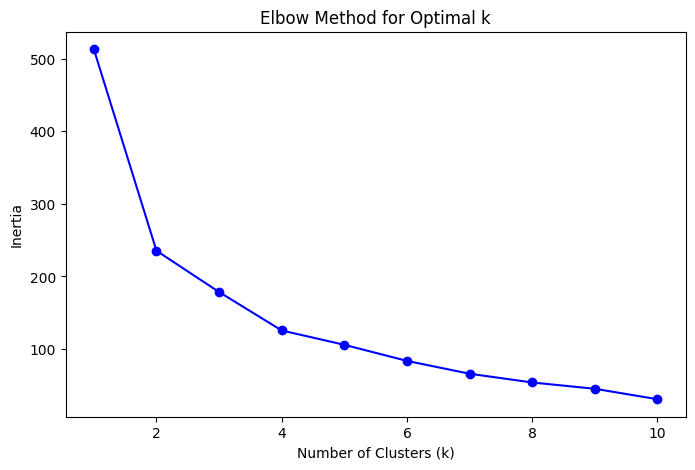

In [ ]:
# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

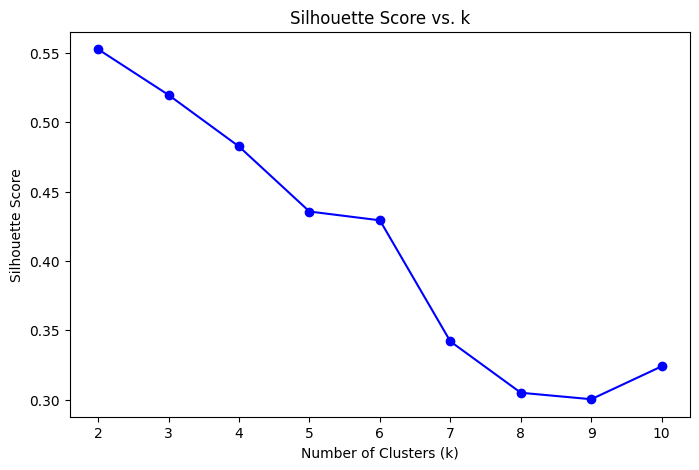

In [ ]:
# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K[1:], silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.show()

In [ ]:
# Apply K-Means with optimal k (k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kqkd_kmean['Cluster'] = kmeans.fit_predict(X_kmean)

In [ ]:
# Evaluate clustering
silhouette_avg = silhouette_score(X_kmean, kqkd_kmean['Cluster'])
print(f'Silhouette Score for k={optimal_k}: {silhouette_avg:.3f}')
print(f'Inertia for k={optimal_k}: {kmeans.inertia_:.2f}')

Silhouette Score for k=3: 0.520
Inertia for k=3: 178.56


In [ ]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_kmean)

In [ ]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("Explained Variance Ratio per Component:\n", explained_variance_ratio)
print("\nCumulative Explained Variance Ratio:\n", cumulative_variance_ratio)

# Select number of components explaining 95% of variance
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNumber of components explaining 95% variance: {n_components}")

Explained Variance Ratio per Component:
 [6.84474764e-01 9.78268220e-02 8.55511326e-02 5.25800491e-02
 3.15038291e-02 1.68796699e-02 1.07200888e-02 9.33270736e-03
 6.16146164e-03 3.21055441e-03 1.29751422e-03 4.32076890e-04
 2.93300549e-05 2.03058045e-33 5.43402088e-34 2.65175019e-34
 1.85204106e-34 1.00789423e-34 4.89406956e-35 3.47858616e-35
 2.40007499e-66]

Cumulative Explained Variance Ratio:
 [0.68447476 0.78230159 0.86785272 0.92043277 0.9519366  0.96881627
 0.97953636 0.98886906 0.99503052 0.99824108 0.99953859 0.99997067
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]

Number of components explaining 95% variance: 5


In [ ]:
# Transform data to selected components
pca = PCA(n_components=5)
X_pca_reduced = pca.fit_transform(X_kmean)

In [ ]:
# Create DataFrame with PCA components
pca_columns = [f'PC{i+1}' for i in range(n_components)]
X_pca_df = pd.DataFrame(X_pca_reduced, index=X_kmean.index, columns=pca_columns)
X_pca_df['Cluster'] = kmeans.fit_predict(X_kmean)

# View loadings
loadings = pd.DataFrame(pca.components_.T, index=X_kmean.columns, columns=pca_columns)
print("\nLoadings (Component Weights):\n", loadings)


Loadings (Component Weights):
                                                              PC1  \
Metric                                                             
KQKD. Chi phí dự phòng rủi ro tín dụng             -2.168758e-01   
KQKD. Chi phí hoạt động                            -2.728403e-01   
KQKD. Chi phí lãi và các chi phí tương tự          -2.549553e-01   
KQKD. Chi phí thuế thu nhập doanh nghiệp           -2.585931e-01   
KQKD. Cổ đông của Công ty mẹ                        2.567716e-01   
KQKD. Khấu hao TSCĐ, bất động sản đầu tư            8.470329e-22   
KQKD. LN thuần từ hoạt động kinh doanh trước CP...  2.740577e-01   
KQKD. Lãi cơ bản trên cổ phiếu                      5.657787e-02   
KQKD. Lãi thuần từ hoạt động dịch vụ                2.293998e-01   
KQKD. Lãi/lỗ thuần từ hoạt động khác                2.306550e-01   
KQKD. Lãi/lỗ thuần từ hoạt động kinh doanh ngoạ...  2.268698e-01   
KQKD. Lãi/lỗ thuần từ mua bán chứng khoán kinh ...  1.451305e-01   
KQKD. Lãi/lỗ thu

Text(0.5, 1.0, 'PCA decomposition')

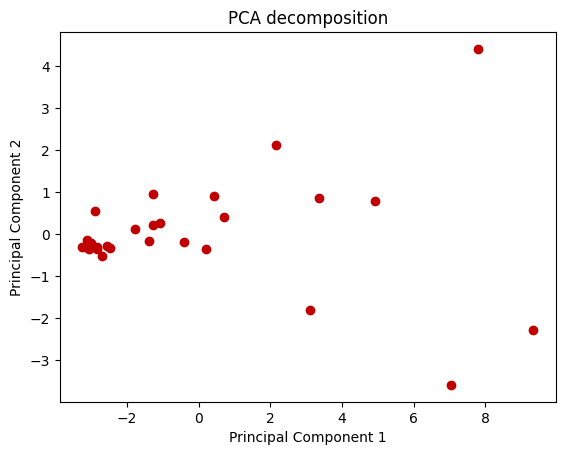

In [ ]:
plt.scatter(X_pca_df['PC1'],X_pca_df['PC2'], color = "#C00000")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA decomposition')

In [ ]:
# Cluster Profiles
cluster_profiles = X_pca_df.groupby('Cluster')[X_pca_df.columns[:-1]].mean()
print("\nCluster Profiles (Mean Values):\n", cluster_profiles)



Cluster Profiles (Mean Values):
               PC1       PC2       PC3       PC4       PC5
Cluster                                                  
0        4.268015  1.271950  1.165237  0.060043  0.450342
1       -1.886290 -0.024604 -0.183915 -0.001076 -0.049873
2        8.192866 -2.933837 -1.073943 -0.139347 -0.627126


In [ ]:
# View the clustered banks
print("\nBanks per Cluster:\n", X_pca_df['Cluster'].value_counts())


Banks per Cluster:
 Cluster
1    20
0     5
2     2
Name: count, dtype: int64


In [ ]:
# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_pca_df.drop('Cluster', axis=1))
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
clusters = kmeans.fit_predict(X_kmean)
pca_df['Cluster'] = clusters

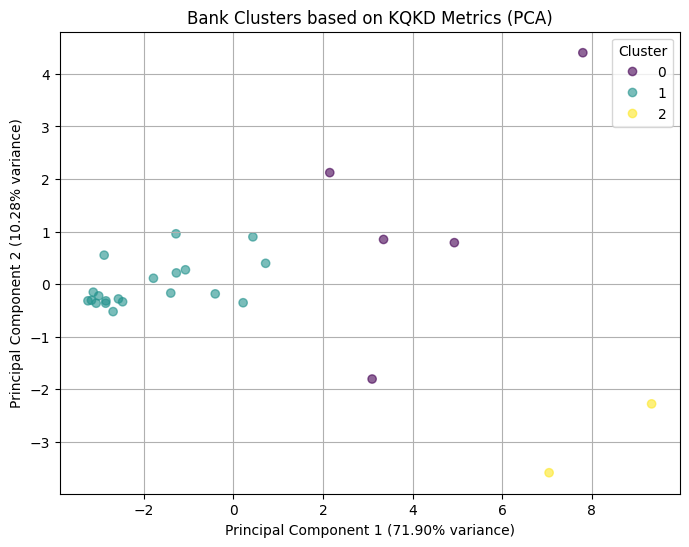

In [ ]:
# Visualize clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'],c=pca_df['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Bank Clusters based on KQKD Metrics (PCA)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.grid(True)
plt.savefig('bank_clusters.png')
plt.show()

In [ ]:
kqkd_kmean.groupby('Cluster').mean()

Metric,KQKD. Chi phí dự phòng rủi ro tín dụng,KQKD. Chi phí hoạt động,KQKD. Chi phí lãi và các chi phí tương tự,KQKD. Chi phí thuế thu nhập doanh nghiệp,KQKD. Cổ đông của Công ty mẹ,"KQKD. Khấu hao TSCĐ, bất động sản đầu tư",KQKD. LN thuần từ hoạt động kinh doanh trước CP dự phòng rủi ro tín dụng,KQKD. Lãi cơ bản trên cổ phiếu,KQKD. Lãi thuần từ hoạt động dịch vụ,KQKD. Lãi/lỗ thuần từ hoạt động khác,...,KQKD. Lãi/lỗ thuần từ mua bán chứng khoán kinh doanh,KQKD. Lãi/lỗ thuần từ mua bán chứng khoán đầu tư,KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp,KQKD. Lợi nhuận trước thuế,KQKD. Lợi ích của cổ đông thiểu số,KQKD. Thu nhập lãi thuần,KQKD. Thu nhập lãi và các khoản thu nhập tương tự,"KQKD. Thu nhập từ góp vốn, mua cổ phần",KQKD. Tổng lợi nhuận kế toán trước thuế,KQKD. Tổng thu nhập hoạt động
Cluster,,,,,,,,,,,,,,,,,,,,,
0,-1.871363e+12,-3.652033e+12,-9.197706e+12,-1.220226e+12,4.823490e+12,0.0,7.937434e+12,260.20,1.375742e+12,3.726802e+11,...,7.571080e+10,3.418370e+11,4.845845e+12,0.0,-2.235480e+10,8.945189e+12,1.814290e+13,4.199560e+10,6.066071e+12,1.158947e+13
1,-3.608032e+11,-9.369227e+11,-3.440848e+12,-1.841868e+11,7.396115e+11,0.0,1.286337e+12,142.05,2.209203e+11,2.334923e+10,...,6.664275e+09,8.509293e+10,7.413474e+11,0.0,-1.735900e+09,1.756776e+12,5.197624e+12,3.144525e+09,9.255343e+11,2.223260e+12
2,-6.694971e+12,-5.563168e+12,-2.203579e+13,-1.070240e+12,4.222978e+12,0.0,1.207684e+13,0.00,1.789711e+12,1.075393e+12,...,4.723000e+10,-1.539305e+11,4.311628e+12,0.0,-8.865100e+10,1.343527e+13,3.547105e+13,3.736100e+10,5.381869e+12,1.764001e+13


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kqkd_kmean['Cluster'] = kmeans.fit_predict(X_kmean)
kqkd_kmean.head(27)


Metric,TICKER,KQKD. Chi phí dự phòng rủi ro tín dụng,KQKD. Chi phí hoạt động,KQKD. Chi phí lãi và các chi phí tương tự,KQKD. Chi phí thuế thu nhập doanh nghiệp,KQKD. Cổ đông của Công ty mẹ,"KQKD. Khấu hao TSCĐ, bất động sản đầu tư",KQKD. LN thuần từ hoạt động kinh doanh trước CP dự phòng rủi ro tín dụng,KQKD. Lãi cơ bản trên cổ phiếu,KQKD. Lãi thuần từ hoạt động dịch vụ,...,KQKD. Lãi/lỗ thuần từ mua bán chứng khoán đầu tư,KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp,KQKD. Lợi nhuận trước thuế,KQKD. Lợi ích của cổ đông thiểu số,KQKD. Thu nhập lãi thuần,KQKD. Thu nhập lãi và các khoản thu nhập tương tự,"KQKD. Thu nhập từ góp vốn, mua cổ phần",KQKD. Tổng lợi nhuận kế toán trước thuế,KQKD. Tổng thu nhập hoạt động,Cluster
0,ABB,-2.358600e+11,-5.549820e+11,-2.052366e+12,-5.972000e+09,2.352900e+10,0.0,2.653610e+11,0.0,1.893660e+11,...,-1.559400e+11,2.352900e+10,0.0,0.000000e+00,6.477270e+11,2.700093e+12,1.759200e+10,2.950100e+10,8.203430e+11,1
1,ACB,-5.206830e+11,-2.868218e+12,-6.814777e+12,-9.979020e+11,4.037579e+12,0.0,5.556164e+12,0.0,7.635870e+11,...,8.819420e+11,4.037579e+12,0.0,0.000000e+00,6.209128e+12,1.302390e+13,3.916600e+10,5.035481e+12,8.424382e+12,0
2,BAB,-2.808300e+10,-4.069940e+11,-2.850115e+12,-1.327600e+10,6.383900e+10,0.0,1.051980e+11,0.0,2.328800e+10,...,1.331500e+10,6.383900e+10,0.0,0.000000e+00,4.262390e+11,3.276354e+12,1.155000e+10,7.711500e+10,5.121920e+11,1
3,BID,-5.949617e+12,-6.044456e+12,-2.432119e+13,-1.164853e+12,4.582880e+12,0.0,1.184240e+13,0.0,1.764252e+12,...,-2.948740e+11,4.727935e+12,0.0,-1.450550e+11,1.378310e+13,3.810429e+13,9.631900e+10,5.892788e+12,1.788686e+13,2
4,BVB,-4.387300e+10,-3.929590e+11,-1.354786e+12,-4.589000e+09,1.705600e+10,0.0,6.551800e+10,0.0,1.660800e+10,...,4.122700e+10,1.705600e+10,0.0,0.000000e+00,3.979910e+11,1.752777e+12,0.000000e+00,2.164500e+10,4.584770e+11,1
5,CTG,-7.440325e+12,-5.081879e+12,-1.975038e+13,-9.756280e+11,3.863075e+12,0.0,1.231128e+13,0.0,1.815170e+12,...,-1.298700e+10,3.895322e+12,0.0,-3.224700e+10,1.308744e+13,3.283782e+13,-2.159700e+10,4.870950e+12,1.739315e+13,2
6,EIB,-1.700130e+11,-7.579890e+11,-2.639171e+12,-6.512900e+10,2.418110e+11,0.0,4.769530e+11,0.0,1.155780e+11,...,1.414970e+11,2.418110e+11,0.0,0.000000e+00,8.687360e+11,3.507907e+12,2.780000e+08,3.069400e+11,1.234942e+12,1
7,HDB,-6.360890e+11,-2.301873e+12,-8.474740e+12,-6.321080e+11,2.480440e+12,0.0,3.783355e+12,0.0,3.179590e+11,...,5.163240e+11,2.515158e+12,0.0,-3.471800e+10,4.916148e+12,1.339089e+13,4.101000e+09,3.147266e+12,6.085228e+12,1
8,KLB,-9.169900e+10,-3.699480e+11,-1.448710e+12,-4.796700e+10,1.892350e+11,0.0,3.289010e+11,0.0,1.613080e+11,...,3.380900e+10,1.892350e+11,0.0,0.000000e+00,4.551140e+11,1.903824e+12,0.000000e+00,2.372020e+11,6.988490e+11,1
9,LPB,-5.326720e+11,-1.340887e+12,-5.447507e+12,-2.478670e+11,9.928500e+11,0.0,1.773389e+12,483.0,1.641830e+11,...,-3.300000e+07,9.928500e+11,0.0,0.000000e+00,2.632779e+12,8.080286e+12,0.000000e+00,1.240717e+12,3.114276e+12,1


In [ ]:
# Reset the index to make 'TICKER' a column
kqkd_kmean = kqkd_kmean.reset_index()

# Select the Ticker column and desired features
df_selected = kqkd_kmean[['TICKER', 'Cluster']]
df_selected.head(100)

Metric,TICKER,Cluster
0,ABB,1
1,ACB,0
2,BAB,1
3,BID,2
4,BVB,1
5,CTG,2
6,EIB,1
7,HDB,1
8,KLB,1
9,LPB,1


In [ ]:
# Group tickers by cluster
clustered = df_selected.groupby('Cluster')['TICKER'].apply(list)
max_len = max(len(tickers) for tickers in clustered)
re_table = pd.DataFrame({f'Cluster {k}': v + [''] * (max_len - len(v)) for k, v in clustered.items()})
re_table.head(100)

,Cluster 0,Cluster 1,Cluster 2
0,ACB,ABB,BID
1,MBB,BAB,CTG
2,TCB,BVB,
3,VCB,EIB,
4,VPB,HDB,
5,,KLB,
6,,LPB,
7,,MSB,
8,,NAB,
9,,NVB,


Hierarchical Clustering

In [ ]:
# Perform hierarchical clustering
Z = linkage(X_hierarchical, method='ward', metric='euclidean')
clusters_1 = fcluster(Z, t=3, criterion='maxclust')  # 3 clusters
X_hierarchical['Cluster'] = clusters_1

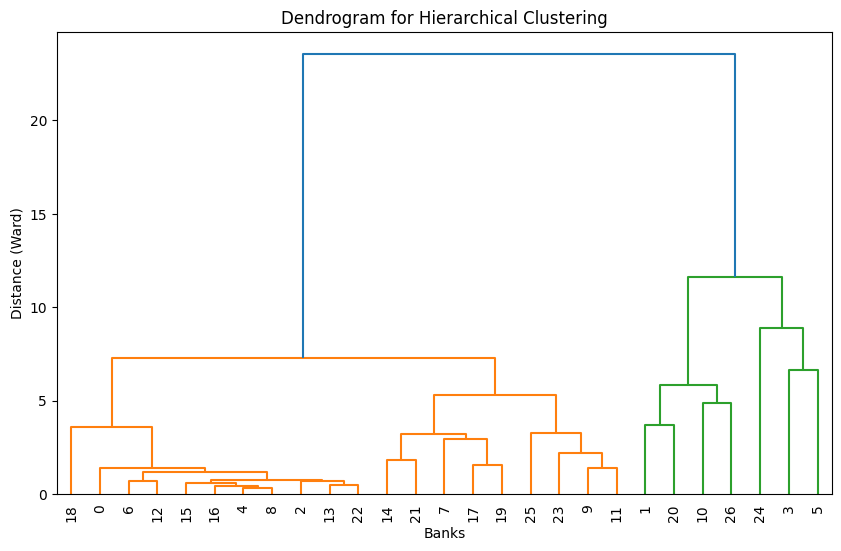

In [ ]:
# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=pca_df.index, leaf_rotation=90)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Banks')
plt.ylabel('Distance (Ward)')
plt.show()

In [ ]:
# Determine clusters (using a distance threshold or number of clusters)
max_d = 10  # Based on dendrogram's green line from earlier visualization
clusters = fcluster(Z, max_d, criterion='distance')
kqkd_hierarchical['Hierarchical_Cluster'] = clusters - 1 # Adjust to 0-based indexing

In [ ]:
kqkd_hierarchical.head(100)

Metric,KQKD. Chi phí dự phòng rủi ro tín dụng,KQKD. Chi phí hoạt động,KQKD. Chi phí lãi và các chi phí tương tự,KQKD. Chi phí thuế thu nhập doanh nghiệp,KQKD. Cổ đông của Công ty mẹ,"KQKD. Khấu hao TSCĐ, bất động sản đầu tư",KQKD. LN thuần từ hoạt động kinh doanh trước CP dự phòng rủi ro tín dụng,KQKD. Lãi cơ bản trên cổ phiếu,KQKD. Lãi thuần từ hoạt động dịch vụ,KQKD. Lãi/lỗ thuần từ hoạt động khác,...,KQKD. Lãi/lỗ thuần từ mua bán chứng khoán đầu tư,KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp,KQKD. Lợi nhuận trước thuế,KQKD. Lợi ích của cổ đông thiểu số,KQKD. Thu nhập lãi thuần,KQKD. Thu nhập lãi và các khoản thu nhập tương tự,"KQKD. Thu nhập từ góp vốn, mua cổ phần",KQKD. Tổng lợi nhuận kế toán trước thuế,KQKD. Tổng thu nhập hoạt động,Hierarchical_Cluster
TICKER,,,,,,,,,,,,,,,,,,,,,
ABB,-2.358600e+11,-5.549820e+11,-2.052366e+12,-5.972000e+09,2.352900e+10,0.0,2.653610e+11,0.0,1.893660e+11,1.114000e+10,...,-1.559400e+11,2.352900e+10,0.0,0.000000e+00,6.477270e+11,2.700093e+12,1.759200e+10,2.950100e+10,8.203430e+11,0
ACB,-5.206830e+11,-2.868218e+12,-6.814777e+12,-9.979020e+11,4.037579e+12,0.0,5.556164e+12,0.0,7.635870e+11,1.470370e+11,...,8.819420e+11,4.037579e+12,0.0,0.000000e+00,6.209128e+12,1.302390e+13,3.916600e+10,5.035481e+12,8.424382e+12,1
BAB,-2.808300e+10,-4.069940e+11,-2.850115e+12,-1.327600e+10,6.383900e+10,0.0,1.051980e+11,0.0,2.328800e+10,2.617000e+09,...,1.331500e+10,6.383900e+10,0.0,0.000000e+00,4.262390e+11,3.276354e+12,1.155000e+10,7.711500e+10,5.121920e+11,0
BID,-5.949617e+12,-6.044456e+12,-2.432119e+13,-1.164853e+12,4.582880e+12,0.0,1.184240e+13,0.0,1.764252e+12,7.410180e+11,...,-2.948740e+11,4.727935e+12,0.0,-1.450550e+11,1.378310e+13,3.810429e+13,9.631900e+10,5.892788e+12,1.788686e+13,2
BVB,-4.387300e+10,-3.929590e+11,-1.354786e+12,-4.589000e+09,1.705600e+10,0.0,6.551800e+10,0.0,1.660800e+10,3.546000e+09,...,4.122700e+10,1.705600e+10,0.0,0.000000e+00,3.979910e+11,1.752777e+12,0.000000e+00,2.164500e+10,4.584770e+11,0
CTG,-7.440325e+12,-5.081879e+12,-1.975038e+13,-9.756280e+11,3.863075e+12,0.0,1.231128e+13,0.0,1.815170e+12,1.409768e+12,...,-1.298700e+10,3.895322e+12,0.0,-3.224700e+10,1.308744e+13,3.283782e+13,-2.159700e+10,4.870950e+12,1.739315e+13,2
EIB,-1.700130e+11,-7.579890e+11,-2.639171e+12,-6.512900e+10,2.418110e+11,0.0,4.769530e+11,0.0,1.155780e+11,3.167900e+10,...,1.414970e+11,2.418110e+11,0.0,0.000000e+00,8.687360e+11,3.507907e+12,2.780000e+08,3.069400e+11,1.234942e+12,0
HDB,-6.360890e+11,-2.301873e+12,-8.474740e+12,-6.321080e+11,2.480440e+12,0.0,3.783355e+12,0.0,3.179590e+11,1.148970e+11,...,5.163240e+11,2.515158e+12,0.0,-3.471800e+10,4.916148e+12,1.339089e+13,4.101000e+09,3.147266e+12,6.085228e+12,0
KLB,-9.169900e+10,-3.699480e+11,-1.448710e+12,-4.796700e+10,1.892350e+11,0.0,3.289010e+11,0.0,1.613080e+11,3.018900e+10,...,3.380900e+10,1.892350e+11,0.0,0.000000e+00,4.551140e+11,1.903824e+12,0.000000e+00,2.372020e+11,6.988490e+11,0


In [ ]:
# View cluster assignments
print("Banks per Hierarchical Cluster:\n", kqkd_hierarchical['Hierarchical_Cluster'].value_counts())


Banks per Hierarchical Cluster:
 Hierarchical_Cluster
0    20
1     4
2     3
Name: count, dtype: int64


In [ ]:
# Cluster Profiles
cluster_profiles = kqkd_hierarchical.groupby('Hierarchical_Cluster').mean()
print("\nCluster Profiles (Mean Values):\n", cluster_profiles)


Cluster Profiles (Mean Values):
 Metric                KQKD. Chi phí dự phòng rủi ro tín dụng  \
Hierarchical_Cluster                                           
0                                              -3.608032e+11   
1                                              -1.965802e+12   
2                                              -4.961183e+12   

Metric                KQKD. Chi phí hoạt động  \
Hierarchical_Cluster                            
0                               -9.369227e+11   
1                               -3.256914e+12   
2                               -5.452947e+12   

Metric                KQKD. Chi phí lãi và các chi phí tương tự  \
Hierarchical_Cluster                                              
0                                                 -3.440848e+12   
1                                                 -8.018061e+12   
2                                                 -1.932929e+13   

Metric                KQKD. Chi phí thuế thu nhập doanh nghiệp 

PCA

In [ ]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(kqkd_hierarchical.drop('Hierarchical_Cluster', axis=1))
X_hierarchical = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
kqkd_hierarchical['Hierarchical_Cluster'] = clusters_1

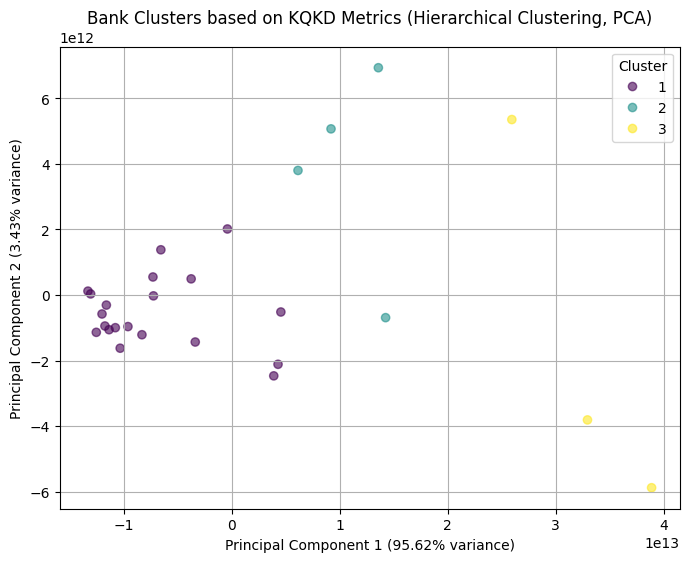

In [ ]:
# Create 2D scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_hierarchical['PC1'], X_hierarchical['PC2'], c=kqkd_hierarchical['Hierarchical_Cluster'], cmap='viridis', alpha=0.6)
plt.title('Bank Clusters based on KQKD Metrics (Hierarchical Clustering, PCA)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.grid(True)
plt.savefig('bank_clusters_hierarchical_2d.png')
plt.show()

In [ ]:
kqkd_hierarchical.head()

Metric,KQKD. Chi phí dự phòng rủi ro tín dụng,KQKD. Chi phí hoạt động,KQKD. Chi phí lãi và các chi phí tương tự,KQKD. Chi phí thuế thu nhập doanh nghiệp,KQKD. Cổ đông của Công ty mẹ,"KQKD. Khấu hao TSCĐ, bất động sản đầu tư",KQKD. LN thuần từ hoạt động kinh doanh trước CP dự phòng rủi ro tín dụng,KQKD. Lãi cơ bản trên cổ phiếu,KQKD. Lãi thuần từ hoạt động dịch vụ,KQKD. Lãi/lỗ thuần từ hoạt động khác,...,KQKD. Lãi/lỗ thuần từ mua bán chứng khoán đầu tư,KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp,KQKD. Lợi nhuận trước thuế,KQKD. Lợi ích của cổ đông thiểu số,KQKD. Thu nhập lãi thuần,KQKD. Thu nhập lãi và các khoản thu nhập tương tự,"KQKD. Thu nhập từ góp vốn, mua cổ phần",KQKD. Tổng lợi nhuận kế toán trước thuế,KQKD. Tổng thu nhập hoạt động,Hierarchical_Cluster
TICKER,,,,,,,,,,,,,,,,,,,,,
ABB,-2.358600e+11,-5.549820e+11,-2.052366e+12,-5.972000e+09,2.352900e+10,0.0,2.653610e+11,0.0,1.893660e+11,1.114000e+10,...,-1.559400e+11,2.352900e+10,0.0,0.000000e+00,6.477270e+11,2.700093e+12,1.759200e+10,2.950100e+10,8.203430e+11,1
ACB,-5.206830e+11,-2.868218e+12,-6.814777e+12,-9.979020e+11,4.037579e+12,0.0,5.556164e+12,0.0,7.635870e+11,1.470370e+11,...,8.819420e+11,4.037579e+12,0.0,0.000000e+00,6.209128e+12,1.302390e+13,3.916600e+10,5.035481e+12,8.424382e+12,2
BAB,-2.808300e+10,-4.069940e+11,-2.850115e+12,-1.327600e+10,6.383900e+10,0.0,1.051980e+11,0.0,2.328800e+10,2.617000e+09,...,1.331500e+10,6.383900e+10,0.0,0.000000e+00,4.262390e+11,3.276354e+12,1.155000e+10,7.711500e+10,5.121920e+11,1
BID,-5.949617e+12,-6.044456e+12,-2.432119e+13,-1.164853e+12,4.582880e+12,0.0,1.184240e+13,0.0,1.764252e+12,7.410180e+11,...,-2.948740e+11,4.727935e+12,0.0,-1.450550e+11,1.378310e+13,3.810429e+13,9.631900e+10,5.892788e+12,1.788686e+13,3
BVB,-4.387300e+10,-3.929590e+11,-1.354786e+12,-4.589000e+09,1.705600e+10,0.0,6.551800e+10,0.0,1.660800e+10,3.546000e+09,...,4.122700e+10,1.705600e+10,0.0,0.000000e+00,3.979910e+11,1.752777e+12,0.000000e+00,2.164500e+10,4.584770e+11,1


In [ ]:
# Reset the index to make 'TICKER' a column
kqkd_hierarchical = kqkd_hierarchical.reset_index()

# Select the Ticker column and desired features
df_selected2 = kqkd_hierarchical[['TICKER','Hierarchical_Cluster']]
df_selected2.head(100)

Metric,TICKER,Hierarchical_Cluster
0,ABB,1
1,ACB,2
2,BAB,1
3,BID,3
4,BVB,1
5,CTG,3
6,EIB,1
7,HDB,1
8,KLB,1
9,LPB,1


In [ ]:
# Group tickers by cluster
clustered2 = df_selected2.groupby('Hierarchical_Cluster')['TICKER'].apply(list)
max_len2 = max(len(tickers) for tickers in clustered)
re_table2 = pd.DataFrame({f'Cluster {k}': v + [''] * (max_len2 - len(v)) for k, v in clustered2.items()})
re_table2.head(100)

,Cluster 1,Cluster 2,Cluster 3
0,ABB,ACB,BID
1,BAB,MBB,CTG
2,BVB,TCB,VCB
3,EIB,VPB,
4,HDB,,
5,KLB,,
6,LPB,,
7,MSB,,
8,NAB,,
9,NVB,,
